# Wat this note can do? 
* This not can make CSV file that summarize inferred selection coefficients
* Selection coefficients shown here are substracted from the TF's coefficients. 
* This process should help to 

Flow of process: 

- reading selection coefficients and csv file that contains HXB2 index. 
- reading sequnce data 
- normalizing selection coefficients. 
- summarizing them in a single csv file. 
- Next, then integrate covariance matrix and numerator across multiple different rhesus macques. 




In [7]:
#Pkg.add("Pkg"); import Pkg; 
ENV["LD_LIBRARY_PATH"] = ""
using Pkg
using Distributed
using DelimitedFiles
using Distances
using StatsBase 
using Profile    
using Random
using Statistics
using LinearAlgebra
using Plots
using Printf
using Measures
using CSV
#using FastaIO
using LaTeXStrings;
using DataFrames
using KernelDensity
rng = Random.MersenneTwister(1234);
PRO = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"];
AA_set = ["-", "A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "*"];
AA2NUM = Dict(AA_set[i] => i for i in 1:length(AA_set));
q = length(AA_set);

In [15]:
include("../src/basic_MPL.jl");
include("../src/basic.jl")
include("../src/my_HIV_data_cleanign.jl")
include("../src/basic_analysis.jl")
include("../src/analysis.jl")
include("../src/non_synonymous_N-glycan.jl") 
include("../src/process_HIV_mutation_for_CSV.jl") 

get_variable_site_true_false (generic function with 1 method)

## CH505 

In [16]:
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

In [17]:
# --- Suppose the CH505's sequence has the complete set of the muations --- #
csv_poly_CH505 = DataFrame(CSV.File( "../mpl/aa_csv/CH505/index-703010505.csv" ));;
seq_TF_aa = csv_poly_CH505.TF; haxb2_TF = csv_poly_CH505.HXB2; seq_consensus_aa = csv_poly_CH505.consensus;
for i_HRM in 1:length(fname_Human_RM)
    # Read CSV
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH505/index-%s.csv", fname_Human_RM[i_HRM])))
    # Read Sequence
    seq_poly = readdlm(@sprintf("../mpl/aa_seq/CH505/%s-poly.num", fname_Human_RM[i_HRM]))
    # Read CSV file 
    coefficients_MPL = readdlm("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/"*fname_Human_RM[i_HRM]*"-poly-AA-MPL.dat")
    coefficients_SL = readdlm("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/"*fname_Human_RM[i_HRM]*"-poly-AA-SL.dat");

    # Formatting sequencies and get frequency 
    seq_TF = copy(csv_poly.TF[csv_poly.polymorphic .!= "NA"]);
    seq_ensemble = Int.(seq_poly[:, 3:end] .+ 1)
    time_set = Int.(seq_poly[:, 1]);

    seq_TF_num = [AA2NUM[x] for x in seq_TF];
    L_poly = length(seq_TF_num);
    time_unique = sort(unique(time_set))
    n_time_unique = length(time_unique)
    x1 = get_x1_AA(time_set, L_poly, q, seq_ensemble);

    # --- Normalization --- #
    (s_normed_MPL, s_normed_SL) = normalize_coefficient_AA(coefficients_MPL, coefficients_SL, q, L_poly, seq_TF, seq_ensemble, seq_TF_num);

    # --- Formatting CSV file --- #
    idx_sort = sortperm(vec(s_normed_MPL), rev=true)
    i_poly_out_set = []; aa_out_set = []; 
    s_mpl_out_set = []; s_sl_out_set = [];
    hxb2_out_set = []; tf_out_set = []; cons_out_set = []
    mut_naive_out_set = []; # compare with TF
    reversion_out_set = []
    #mut_out_set = []; # consider the previous temporal state
    date_first_detected = [];
    freq_set = [[] for _ in 1:n_time_unique]
    for n in 1:length(idx_sort)
        i_raw = idx_sort[n]
        s_mpl = s_normed_MPL[i_raw]
        s_sl = s_normed_MPL[i_raw]
        i_poly = Int(ceil(i_raw / q))

        a_poly_num = i_raw - (i_poly-1) * q
        a_poly = AA_set[a_poly_num]

        idx_csv = (csv_poly.polymorphic .== string(i_poly))
        i_poly_out = csv_poly.polymorphic[idx_csv][1]
        hxb2_out = csv_poly.HXB2[idx_csv][1]

        if( !( abs(s_mpl)<1e-7) )
            tf_out = csv_poly.TF[idx_csv][1]
            consensus_out = csv_poly.consensus[idx_csv][1]
            date_detected = get_first_detected(time_unique, x1, i_poly, a_poly_num)
            #@show i_poly, a_poly, i_poly_out, hxb2_out, tf_out, consensus_out, date_detected
            if((a_poly==consensus_out) && (a_poly!=tf_out)) push!(reversion_out_set, true) else push!(reversion_out_set, false) end
            push!(hxb2_out_set, hxb2_out)
            push!(i_poly_out_set, i_poly)
            push!(aa_out_set, a_poly)
            push!(tf_out_set, tf_out)
            push!(cons_out_set, consensus_out)
            push!(mut_naive_out_set, @sprintf("%s%s%s", tf_out, hxb2_out, a_poly))
            push!(date_first_detected, date_detected)
            push!(s_mpl_out_set, @sprintf("%.7f", s_mpl))
            push!(s_sl_out_set, @sprintf("%.7f", s_sl))
        
            for i_t in 1:n_time_unique
                push!(freq_set[i_t], @sprintf("%.3f", x1[i_t, i_poly, a_poly_num]))
            end
        
        end
    end
   
    (glycan_plus_set, glycan_minus_set) = get_glycan_plus_minus_AA_seq(seq_TF_aa, haxb2_TF, hxb2_out_set, aa_out_set)
    @printf("N+:%d, N-:%d, N±:%d\n", count(glycan_plus_set), count(glycan_minus_set), count(glycan_plus_set .* glycan_minus_set))
    (V1_set_temp, V2_set_temp, V3_set_temp, V4_set_temp, V5_set_temp, LD_set_temp, CD4BS_set_temp) = get_variable_site_true_false(hxb2_out_set)
    
    df = DataFrame(
        HXB2=hxb2_out_set, 
        polymorphic=i_poly_out_set, 
        PRO=aa_out_set, 
        TF=tf_out_set,
        consensus=cons_out_set,
        reversion=reversion_out_set,
        mutation=mut_naive_out_set, 
        date=date_first_detected,
        V1=V1_set_temp,
        V2=V2_set_temp,
        V3=V3_set_temp,
        V4=V4_set_temp,
        V5=V5_set_temp,
        LD=LD_set_temp,
        CD4BS=CD4BS_set_temp,
        glycan_plus=glycan_plus_set, 
        glycan_minus=glycan_minus_set, 
        s_MPL=s_mpl_out_set, 
        s_SL=s_sl_out_set, 
    )
    for i_t in 1:n_time_unique 
        df[!, @sprintf("f_at_%s", time_unique[i_t])] = freq_set[i_t]
    end


    CSV.write(@sprintf("../mpl/aa_csv/CH505/%s-poly.csv", fname_Human_RM[i_HRM]), df);

end

N+:12, N-:97, N±:4
N+:10, N-:47, N±:4
N+:7, N-:63, N±:4
N+:1, N-:15, N±:1
N+:2, N-:16, N±:1
N+:5, N-:43, N±:2
N+:3, N-:38, N±:1
N+:3, N-:21, N±:2


## CH848 

In [18]:
fname_Human_RM = ["703010848", "RM6163", "RM6167", "RM6700", "RM6713", "RM6714", "RM6720"];

In [19]:
csv_poly_CH848 = DataFrame(CSV.File( "../mpl/aa_csv/CH848/index-703010848.csv" ));;
seq_TF_aa = csv_poly_CH848.TF; haxb2_TF = csv_poly_CH848.HXB2; seq_consensus_aa = csv_poly_CH848.consensus;

for i_HRM in 1:length(fname_Human_RM)
    # Read CSV
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH848/index-%s.csv", fname_Human_RM[i_HRM])))
    # Read Sequence
    seq_poly = readdlm(@sprintf("../mpl/aa_out/CH848/%s-poly.num", fname_Human_RM[i_HRM]))
    # Read CSV file 
    coefficients_MPL = readdlm("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH848/"*fname_Human_RM[i_HRM]*"-poly-AA-MPL.dat")
    coefficients_SL = readdlm("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH848/"*fname_Human_RM[i_HRM]*"-poly-AA-SL.dat");

    # Formatting sequencies and get frequency 
    seq_TF = copy(csv_poly.TF[csv_poly.polymorphic .!= "NA"]);
    seq_ensemble = Int.(seq_poly[:, 3:end] .+ 1)
    time_set = Int.(seq_poly[:, 1]);

    seq_TF_num = [AA2NUM[x] for x in seq_TF];
    L_poly = length(seq_TF_num);
    time_unique = sort(unique(time_set))
    n_time_unique = length(time_unique)
    x1 = get_x1_AA(time_set, L_poly, q, seq_ensemble);

    # --- Normalization --- #
    (s_normed_MPL, s_normed_SL) = normalize_coefficient_AA(coefficients_MPL, coefficients_SL, q, L_poly, seq_TF, seq_ensemble, seq_TF_num);

    # --- Formatting CSV file --- #
    idx_sort = sortperm(vec(s_normed_MPL), rev=true)
    i_poly_out_set = []; aa_out_set = []; 
    s_mpl_out_set = []; s_sl_out_set = [];
    hxb2_out_set = []; tf_out_set = []; cons_out_set = []
    mut_naive_out_set = []; # compare with TF
    reversion_out_set = []
    #mut_out_set = []; # consider the previous temporal state
    date_first_detected = [];
    freq_set = [[] for _ in 1:n_time_unique]
    for n in 1:length(idx_sort)
        i_raw = idx_sort[n]
        s_mpl = s_normed_MPL[i_raw]
        s_sl = s_normed_MPL[i_raw]
        i_poly = Int(ceil(i_raw/ q))

        a_poly_num = i_raw - (i_poly-1)*q
        a_poly = AA_set[a_poly_num]

        idx_csv = (csv_poly.polymorphic .== string(i_poly))
        i_poly_out = csv_poly.polymorphic[idx_csv][1]
        hxb2_out = csv_poly.HXB2[idx_csv][1]

        if( !( abs(s_mpl)<1e-7) )

            tf_out = csv_poly.TF[idx_csv][1]
            consensus_out = csv_poly.consensus[idx_csv][1]
            date_detected = get_first_detected(time_unique, x1, i_poly, a_poly_num)
            if((a_poly==consensus_out) && (a_poly!=tf_out)) push!(reversion_out_set, true) else push!(reversion_out_set, false) end
            #@show i_poly, a_poly, i_poly_out, hxb2_out, tf_out, consensus_out, date_detected
            push!(hxb2_out_set, hxb2_out)
            push!(i_poly_out_set, i_poly)
            push!(aa_out_set, a_poly)
            push!(tf_out_set, tf_out)
            push!(cons_out_set, consensus_out)
            push!(mut_naive_out_set, @sprintf("%s%s%s", tf_out, hxb2_out, a_poly))
            push!(date_first_detected, date_detected)
            push!(s_mpl_out_set, @sprintf("%.7f", s_mpl))
            push!(s_sl_out_set, @sprintf("%.7f", s_sl))
        
            for i_t in 1:n_time_unique
                push!(freq_set[i_t], @sprintf("%.3f", x1[i_t, i_poly, a_poly_num]))
            end
        
        end
    end
    (glycan_plus_set, glycan_minus_set) = get_glycan_plus_minus_AA_seq(seq_TF_aa, haxb2_TF, hxb2_out_set, aa_out_set)
    @printf("N+:%d, N-:%d, N±:%d\n", count(glycan_plus_set), count(glycan_minus_set), count(glycan_plus_set .* glycan_minus_set))
    (V1_set_temp, V2_set_temp, V3_set_temp, V4_set_temp, V5_set_temp, LD_set_temp, CD4BS_set_temp) = get_variable_site_true_false(hxb2_out_set)
    df = DataFrame(
        HXB2=hxb2_out_set, 
        polymorphic=i_poly_out_set, 
        PRO=aa_out_set, 
        TF=tf_out_set,
        consensus=cons_out_set,
        reversion=reversion_out_set,
        mutation=mut_naive_out_set, 
        date=date_first_detected,
        V1=V1_set_temp,
        V2=V2_set_temp,
        V3=V3_set_temp,
        V4=V4_set_temp,
        V5=V5_set_temp,
        LD=LD_set_temp,
        CD4BS=CD4BS_set_temp,
        glycan_plus=glycan_plus_set, 
        glycan_minus=glycan_minus_set, 
        s_MPL=s_mpl_out_set, 
        s_SL=s_sl_out_set, 
    )

    for i_t in 1:n_time_unique 
        df[!, @sprintf("f_at_%s", time_unique[i_t])] = freq_set[i_t]
    end


    CSV.write(@sprintf("../mpl/aa_csv/CH848/%s-poly.csv", fname_Human_RM[i_HRM]), df);

end

N+:24, N-:227, N±:5
N+:7, N-:54, N±:3
N+:12, N-:79, N±:3
N+:11, N-:90, N±:3
N+:8, N-:39, N±:2
N+:8, N-:61, N±:3
N+:5, N-:36, N±:1


# Marginalizing covariance and numerator; 

## CH505 

In [20]:
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];


In [21]:
i_HRM = 2
csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH505/index-%s.csv", fname_Human_RM[i_HRM])));
cov_raw = readdlm(@sprintf("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/covariance-%s-poly-AA.dat", fname_Human_RM[i_HRM]))
num_raw = readdlm(@sprintf("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/numerator-%s-poly-AA.dat", fname_Human_RM[i_HRM]));
coefficients_MPL = readdlm("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/"*fname_Human_RM[i_HRM]*"-poly-AA-MPL.dat");

In [201]:
# This takes 283.425596 sec.
#γ = 10 ;
#@time s_temp = (cov_raw + γ*I) \ num_raw;

In [118]:
# --- Define HXB2 set that are appeared on RMs at least once --- #
HXB2_set = []
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH505/index-%s.csv", fname_Human_RM[i_HRM])));
    for x in csv_poly.HXB2
        if(x ∉ HXB2_set )
            push!(HXB2_set, x)
        end
    end
end;

HXB2_set = copy(unique(HXB2_set));

# --- Set global "polymorphic" indicies across multiple RMs --- #
indicator_poly_set = [false for _ in HXB2_set];
TF_set = ["-" for _ in HXB2_set]
# A function that maps polymorphic index in RM to another "polymorphic of RMs"
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH505/index-%s.csv", fname_Human_RM[i_HRM])));
    non_NA_sites = csv_poly.HXB2[csv_poly.polymorphic .!= "NA"]
    for i in 1:length(HXB2_set)
        hxb2 = HXB2_set[i]
        if(hxb2 ∈ non_NA_sites)
            indicator_poly_set[i] = true
        end
    end    
  
end
poly_set = ["NA" for _ in HXB2_set];
L_RM = count(indicator_poly_set)
poly_set[indicator_poly_set] = string.(collect(1:L_RM));

# ------ make mapping between individual poly indicies to marginalized poly indicies ----- #;
HXB2_poly = HXB2_set[indicator_poly_set];
poly2poly_map = [[] for _ in 1:length(fname_Human_RM)]
num_set_temp = collect(1:length(HXB2_poly))
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH505/index-%s.csv", fname_Human_RM[i_HRM])));
    # --- Get indecies set that maps inidividual polymorphic sites to global polymorphic sites. --- #
    for x in csv_poly.HXB2[csv_poly.polymorphic .!= "NA"];
        idx = num_set_temp[HXB2_poly .== x]
        push!(poly2poly_map[i_HRM], idx[1])
    end;
end
# ----- Just for obtaining TF and aonsenssus----- #
TF_RMs_set = ["NA" for _ in HXB2_set]
consensus_RMs_set = ["NA" for _ in HXB2_set]
num_temp = collect(1:length(HXB2_set))
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH505/index-%s.csv", fname_Human_RM[i_HRM])));
    
    for k in 1:length(csv_poly.HXB2)
        if(csv_poly.polymorphic[k] != "NA")
            hxb2 = csv_poly.HXB2[k]
            idx = HXB2_set .== hxb2
            TF_RMs_set[num_temp[idx][1]] = string(csv_poly.TF[k][1])
            consensus_RMs_set[num_temp[idx][1]] = string(csv_poly.consensus[k][1])
        end 
    end
end


In [119]:
# ---- Marginalizing cov and num ---- #
cov_RM = zeros(q*L_RM, q*L_RM)
num_RM = zeros(q*L_RM);

for i_HRM in 2:length(fname_Human_RM)
    cov_raw = readdlm(@sprintf("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/covariance-%s-poly-AA.dat", fname_Human_RM[i_HRM]))
    num_raw = readdlm(@sprintf("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH505/numerator-%s-poly-AA.dat", fname_Human_RM[i_HRM]));
    poly_idx = copy(poly2poly_map[i_HRM]);
    @assert length(num_raw) == q*length(poly_idx)
    for i in 1:length(poly_idx)
        i_poly = poly_idx[i]
        num_RM[km.(i_poly, 1:q, q)] += num_raw[km.(i, 1:q, q)]
        for j in 1:length(poly_idx)
            j_poly = poly_idx[j]
            cov_RM[km.(i_poly, 1:q, q), km.(j_poly, 1:q, q)] += cov_raw[km.(i, 1:q, q), km.(j, 1:q, q)]
        end
    end
end

# ----- Write out integrated cov and num to CSV files ----- #
fout_num = open("../mpl/aa_out/CH505/numerator-RMs-poly-AA.dat", "w")
for x in num_RM
    println(fout_num, x)
end
close(fout_num)

fout_cov = open("../mpl/aa_out/CH505/covariance-RMs-poly-AA.dat", "w")
for i in 1:size(cov_RM,1)
    println(fout_cov, @sprintf("%s", join(cov_RM[i, :], " ")))
end
close(fout_cov);

df = DataFrame(
        HXB2=HXB2_set, 
        polymorphic=poly_set, 
        TF=TF_RMs_set, 
        consensus=consensus_RMs_set
    )

CSV.write("../mpl/aa_csv/CH505/index-RMs-poly.csv", df);


LoadError: at row 2863, column 549 : InterruptException())

In [120]:
γ = 10
@time s_MPL_RM = (cov_RM + γ*I) \ num_RM;
@time s_SL_RM =  num_RM ./ (cov_RM[diagind(cov_RM)] .+ γ);

fout_mpl = open("../mpl/aa_out/CH505/RMs-poly-AA-MPL.dat", "w")
fout_sl = open("../mpl/aa_out/CH505/RMs-poly-AA-SL.dat", "w")
for x in s_MPL_RM
    println(fout_mpl, x)
end
close(fout_mpl)
#
for x in s_SL_RM
    println(fout_sl, x)
end
close(fout_sl);

LoadError: InterruptException:

## CH848 

In [22]:
fname_Human_RM = ["703010505", "RM6163", "RM6167", "RM6700", "RM6713", "RM6714", "RM6720" ];

In [23]:
# --- Define HXB2 set that are appeared on RMs at least once --- #
HXB2_set = []
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH848/index-%s.csv", fname_Human_RM[i_HRM])));
    for x in csv_poly.HXB2
        if(x ∉ HXB2_set )
            push!(HXB2_set, x)
        end
    end
end;

HXB2_set = copy(unique(HXB2_set));

# --- Set global "polymorphic" indicies across multiple RMs --- #
indicator_poly_set = [false for _ in HXB2_set];
TF_set = ["-" for _ in HXB2_set]
# A function that maps polymorphic index in RM to another "polymorphic of RMs"
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH848/index-%s.csv", fname_Human_RM[i_HRM])));
    non_NA_sites = csv_poly.HXB2[csv_poly.polymorphic .!= "NA"]
    for i in 1:length(HXB2_set)
        hxb2 = HXB2_set[i]
        if(hxb2 ∈ non_NA_sites)
            indicator_poly_set[i] = true
        end
    end    
  
end
poly_set = ["NA" for _ in HXB2_set];
L_RM = count(indicator_poly_set)
poly_set[indicator_poly_set] = string.(collect(1:L_RM));

# ------ make mapping between individual poly indicies to marginalized poly indicies ----- #;
HXB2_poly = HXB2_set[indicator_poly_set];
poly2poly_map = [[] for _ in 1:length(fname_Human_RM)]
num_set_temp = collect(1:length(HXB2_poly))
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH848/index-%s.csv", fname_Human_RM[i_HRM])));
    # --- Get indecies set that maps inidividual polymorphic sites to global polymorphic sites. --- #
    for x in csv_poly.HXB2[csv_poly.polymorphic .!= "NA"];
        idx = num_set_temp[HXB2_poly .== x]
        push!(poly2poly_map[i_HRM], idx[1])
    end;
end
# ----- Just for obtaining TF and aonsenssus----- #
TF_RMs_set = ["NA" for _ in HXB2_set]
consensus_RMs_set = ["NA" for _ in HXB2_set]
num_temp = collect(1:length(HXB2_set))
for i_HRM in 2:length(fname_Human_RM)
    csv_poly = DataFrame(CSV.File(@sprintf("../mpl/aa_csv/CH848/index-%s.csv", fname_Human_RM[i_HRM])));
    
    for k in 1:length(csv_poly.HXB2)
        if(csv_poly.polymorphic[k] != "NA")
            hxb2 = csv_poly.HXB2[k]
            idx = HXB2_set .== hxb2
            TF_RMs_set[num_temp[idx][1]] = string(csv_poly.TF[k][1])
            consensus_RMs_set[num_temp[idx][1]] = string(csv_poly.consensus[k][1])
        end 
    end
end


In [ ]:
# ---- Marginalizing cov and num ---- #
cov_RM = zeros(q*L_RM, q*L_RM)
num_RM = zeros(q*L_RM);

for i_HRM in 2:length(fname_Human_RM)
    cov_raw = readdlm(@sprintf("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH848/covariance-%s-poly-AA.dat", fname_Human_RM[i_HRM]))
    num_raw = readdlm(@sprintf("/net/dali/home/barton/kais/MPL_AA_rhesus/HIV/CH848/numerator-%s-poly-AA.dat", fname_Human_RM[i_HRM]));
    poly_idx = copy(poly2poly_map[i_HRM]);
    @assert length(num_raw) == q*length(poly_idx)
    for i in 1:length(poly_idx)
        i_poly = poly_idx[i]
        num_RM[km.(i_poly, 1:q, q)] += num_raw[km.(i, 1:q, q)]
        for j in 1:length(poly_idx)
            j_poly = poly_idx[j]
            cov_RM[km.(i_poly, 1:q, q), km.(j_poly, 1:q, q)] += cov_raw[km.(i, 1:q, q), km.(j, 1:q, q)]
        end
    end
end

# ----- Write out integrated cov and num to CSV files ----- #
fout_num = open("../mpl/aa_out/CH848/numerator-RMs-poly-AA.dat", "w")
for x in num_RM
    println(fout_num, x)
end
close(fout_num)

fout_cov = open("../mpl/aa_out/CH848/covariance-RMs-poly-AA.dat", "w")
for i in 1:size(cov_RM,1)
    println(fout_cov, @sprintf("%s", join(cov_RM[i, :], " ")))
end
close(fout_cov);

# --- I need to include V1-V5, CD4, LD, Glycan alter.
# --> To compute the glycan I need to fix the TF sequence then identify the 
# consider to use the function. 
df = DataFrame(
        HXB2=HXB2_set, 
        polymorphic=poly_set, 
        TF=TF_RMs_set, 
        consensus=consensus_RMs_set
    )

CSV.write("../mpl/aa_csv/CH848/index-RMs-poly.csv", df);


In [ ]:
γ = 10
@time s_MPL_RM = (cov_RM + γ*I) \ num_RM;
@time s_SL_RM =  num_RM ./ (cov_RM[diagind(cov_RM)] .+ γ);

fout_mpl = open("../mpl/aa_out/CH848/RMs-poly-AA-MPL.dat", "w")
fout_sl = open("../mpl/aa_out/CH848/RMs-poly-AA-SL.dat", "w")
for x in s_MPL_RM
    println(fout_mpl, x)
end
close(fout_mpl)
#
for x in s_SL_RM
    println(fout_sl, x)
end
close(fout_sl);

# Making CSV for marginalized RMs.

In [ ]:
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

In [ ]:
csv_poly = DataFrame(CSV.File("../mpl/aa_csv/CH505/index-RMs-poly.csv"))
# Read CSV file 
coefficients_MPL = readdlm("../mpl/aa_out/CH505/RMs-poly-AA-MPL.dat")
coefficients_SL = readdlm("../mpl/aa_out/CH505/RMs-poly-AA-SL.dat");


In [ ]:
# Formatting sequencies and get frequency 
seq_TF = copy(csv_poly.TF[csv_poly.polymorphic .!= "NA"]);
seq_TF_num = [AA2NUM[x] for x in seq_TF];
L_poly = length(seq_TF_num)
# --- Normalization --- #
(s_normed_MPL, s_normed_SL) = normalize_coefficient_AA(coefficients_MPL, coefficients_SL, q, L_poly, seq_TF)
# --- Formatting CSV file --- #
idx_sort = sortperm(vec(s_normed_MPL), rev=true)

i_poly_out_set = []; aa_out_set = []; 
s_mpl_out_set = []; s_sl_out_set = [];
hxb2_out_set = []; tf_out_set = []; cons_out_set = []
mut_naive_out_set = []; # compare with TF

for n in 1:length(idx_sort)
    i_raw = idx_sort[n]
    s_mpl = s_normed_MPL[i_raw]
    s_sl = s_normed_MPL[i_raw]
    i_poly = Int(ceil(i_raw/ q))

    a_poly_num = i_raw - (i_poly-1)*q
    a_poly = AA_set[a_poly_num]

    idx_csv = (csv_poly.polymorphic .== string(i_poly))
    i_poly_out = csv_poly.polymorphic[idx_csv][1]
    hxb2_out = csv_poly.HXB2[idx_csv][1]

    if( !( abs(s_mpl)<1e-7) )
        tf_out = csv_poly.TF[idx_csv][1]
        consensus_out = csv_poly.consensus[idx_csv][1]
        push!(hxb2_out_set, hxb2_out)
        push!(i_poly_out_set, i_poly)
        push!(aa_out_set, a_poly)
        push!(tf_out_set, tf_out)
        push!(cons_out_set, consensus_out)
        push!(mut_naive_out_set, @sprintf("%s%s%s", tf_out, hxb2_out, a_poly))
        push!(s_mpl_out_set, @sprintf("%.7f", s_mpl))
        push!(s_sl_out_set, @sprintf("%.7f", s_sl))        
    end
end

df = DataFrame(
    HXB2=hxb2_out_set, 
    polymorphic=i_poly_out_set, 
    PRO=aa_out_set, 
    TF=tf_out_set,
    consensus=cons_out_set,
    mutation=mut_naive_out_set, 
    s_MPL=s_mpl_out_set, 
    s_SL=s_sl_out_set, 
)
CSV.write("../mpl/aa_csv/CH505/RMs-poly.csv", df);


## CH848

In [ ]:
fname_Human_RM = ["703010505", "RM6163", "RM6167", "RM6700", "RM6713", "RM6714", "RM6720" ];

In [ ]:
csv_poly = DataFrame(CSV.File("../mpl/aa_csv/CH848/index-RMs-poly.csv"))
# Read CSV file 
coefficients_MPL = readdlm("../mpl/aa_out/CH848/RMs-poly-AA-MPL.dat")
coefficients_SL = readdlm("../mpl/aa_out/CH848/RMs-poly-AA-SL.dat");


In [ ]:
# Formatting sequencies and get frequency 
seq_TF = copy(csv_poly.TF[csv_poly.polymorphic .!= "NA"]);
seq_TF_num = [AA2NUM[x] for x in seq_TF];
L_poly = length(seq_TF_num)
# --- Normalization --- #
(s_normed_MPL, s_normed_SL) = normalize_coefficient_AA(coefficients_MPL, coefficients_SL, q, L_poly, seq_TF)
# --- Formatting CSV file --- #
idx_sort = sortperm(vec(s_normed_MPL), rev=true)

i_poly_out_set = []; aa_out_set = []; 
s_mpl_out_set = []; s_sl_out_set = [];
hxb2_out_set = []; tf_out_set = []; cons_out_set = []
mut_naive_out_set = []; # compare with TF

for n in 1:length(idx_sort)
    i_raw = idx_sort[n]
    s_mpl = s_normed_MPL[i_raw]
    s_sl = s_normed_MPL[i_raw]
    i_poly = Int(ceil(i_raw/ q))

    a_poly_num = i_raw - (i_poly-1)*q
    a_poly = AA_set[a_poly_num]

    idx_csv = (csv_poly.polymorphic .== string(i_poly))
    i_poly_out = csv_poly.polymorphic[idx_csv][1]
    hxb2_out = csv_poly.HXB2[idx_csv][1]

    if( !( abs(s_mpl)<1e-7) )
        tf_out = csv_poly.TF[idx_csv][1]
        consensus_out = csv_poly.consensus[idx_csv][1]
        push!(hxb2_out_set, hxb2_out)
        push!(i_poly_out_set, i_poly)
        push!(aa_out_set, a_poly)
        push!(tf_out_set, tf_out)
        push!(cons_out_set, consensus_out)
        push!(mut_naive_out_set, @sprintf("%s%s%s", tf_out, hxb2_out, a_poly))
        push!(s_mpl_out_set, @sprintf("%.7f", s_mpl))
        push!(s_sl_out_set, @sprintf("%.7f", s_sl))        
    end
end

df = DataFrame(
    HXB2=hxb2_out_set, 
    polymorphic=i_poly_out_set, 
    PRO=aa_out_set, 
    TF=tf_out_set,
    consensus=cons_out_set,
    mutation=mut_naive_out_set, 
    s_MPL=s_mpl_out_set, 
    s_SL=s_sl_out_set, 
)
CSV.write("../mpl/aa_csv/CH848/RMs-poly.csv", df);


# Compute enrichment ratio for macaques and make a CSV file.

In [22]:
function get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in, idx_significant)
    # The following computation is similar to the n_null and N_null computation
    n_nsyn_restricted = 0
    seq_TF = copy(csv_index_and_TF.TF);
    L_TF = length(csv_index_and_TF.HXB2)
    for i_eff in 1:count(idx_significant)
        idx_mached = csv_index_and_TF.HXB2 .== csv_raw_in.HXB2_index[i_eff]
        if(count(idx_mached)>0)        
            i_raw = collect(1:L_TF)[idx_mached][1] # This line is clitical to get the HXB2 index in TF seq.
            aa_MT = csv_raw_in.PRO[i_eff]
            aa_TF = seq_TF[i_raw]
    
            if(aa_MT != aa_TF && aa_TF != "-")
                if(idx_type_in[i_eff])
                    n_nsyn_restricted += 1
                end
            end
        end
    end
    return n_nsyn_restricted
end;

In [23]:
function get_n_sel_and_N_sel_reversion_AA(csv_raw_in, csv_index_and_TF, idx_significant)
    n_nsyn_restricted, n_nsyn = 0, 0
    seq_TF = copy(csv_index_and_TF.TF);
    seq_consensus = copy(csv_index_and_TF.consensus)
    L_TF = length(csv_index_and_TF.HXB2)
    for i_eff in 1:count(idx_significant)
        idx_mached = csv_index_and_TF.HXB2 .== csv_raw_in.HXB2_index[i_eff]
        if(count(idx_mached)>0)        
            i_raw = collect(1:L_TF)[idx_mached][1] # This line is clitical to get the HXB2 index in TF seq.
            aa_consensus = seq_consensus[i_raw]
            aa_MT = csv_raw_in.PRO[i_eff]
            aa_TF = seq_TF[i_raw]
            
            idx_hxb2 = extract_integer(csv_raw_in.HXB2_index[i_eff])
            this_frame_set, this_gene_set = index2frame(idx_hxb2)
            if(aa_TF != "-" && aa_MT != aa_TF)
                n_nsyn += 1
                if(csv_raw_in.reversion[i_eff])
                    n_nsyn_restricted += 1 
                end
            end
        end
    end
    
    return (n_nsyn_restricted, n_nsyn) 
end;

In [24]:
function get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_type)
    n_nsyn_restricted, n_nsyn = 0, 0
    seq_TF = copy(csv_index_and_TF.TF);
    for i_raw in 1:length(seq_TF)
        aa_TF = seq_TF[i_raw]
        idx_hxb2 = extract_integer(csv_index_and_TF.HXB2[i_raw])
        this_frame_set, this_gene_set = index2frame(idx_hxb2)
        if(aa_TF != "-")
            for aa_MT in PRO
                if(aa_MT != aa_TF && aa_MT != "-")
                    n_nsyn += 1
                    if(idx_hxb2 ∈ idx_HXB2_type) 
                        n_nsyn_restricted += 1
                    end
                end
            end
        end
    end
     
    return (n_nsyn_restricted, n_nsyn)
end

get_num_of_nonsyn_AA (generic function with 1 method)

In [25]:

# idx_type is not necessary for this function. --> need to fix this!
function get_num_of_nonsyn_reversion_AA(csv_index_and_TF)
    n_nsyn_restricted, n_nsyn = 0, 0
    seq_TF = copy(csv_index_and_TF.TF);
    seq_consensus = copy(csv_index_and_TF.consensus)
    for i_raw in 1:length(seq_TF)
        aa_TF = seq_TF[i_raw]
        aa_consensus = seq_consensus[i_raw]
        idx_hxb2 = extract_integer(csv_index_and_TF.HXB2[i_raw])
        this_frame_set, this_gene_set = index2frame(idx_hxb2)
        if(aa_TF != "-")  
            for aa_MT in PRO
                if(aa_MT != aa_TF && aa_MT != "-") 
                    n_nsyn += 1 
                    if(aa_MT == aa_consensus) n_nsyn_restricted += 1 end
                end
            end
        end
    end
    return (n_nsyn_restricted, n_nsyn)
end;

In [26]:
# ---- The following file shouldn't be modified (don't directly manuplate the coxde, but try to addapt he input files. ----
function log_factorial_stirling(n)
    if n <=0
        return 0.0
    else
        return (n * log(n) - n + log(2π * n) / 2) / log(10)  # Stiring's approximation.
    end
end

function log_binomial_coefficient(n, k)
    return log_factorial_stirling(n) - log_factorial_stirling(k) - log_factorial_stirling(n - k)
end

function fishers_exact_test(A, B, C, D)
    total = A + B + C + D
    #@printf("A+B:%d\tA:%d\tC+D:%d\tC:%d\ttotal:%d\tA+D:%d\n", A, B, C, D, total, A+D)
    log_p_value = log_binomial_coefficient(A + B, A) + 
                  log_binomial_coefficient(C + D, C) - 
                  log_binomial_coefficient(total, A + C)
    return log_p_value
end;

function get_enrichment_and_pvalues_AA(csv_raw_in, csv_index_and_TF, α_selected_list)
    x_fold_V1_set = []; n_fold_V1_set = []; fisher_V1_set = []
    x_fold_V2_set = []; n_fold_V2_set = []; fisher_V2_set = []
    x_fold_V3_set = []; n_fold_V3_set = []; fisher_V3_set = []
    x_fold_V4_set = []; n_fold_V4_set = []; fisher_V4_set = []
    x_fold_V5_set = []; n_fold_V5_set = []; fisher_V5_set = []
    x_fold_reversion_set = []; n_fold_reversion_set = []; fisher_reversion_set = []
    x_fold_LoopD_set = []; n_fold_LoopD_set = []; fisher_LoopD_set = []
    x_fold_CD4BS_set = []; n_fold_CD4BS_set = []; fisher_CD4BS_set = []
    x_fold_N_any_set = []; n_fold_N_any_set = []; fisher_N_any_set = []
    x_fold_N_rem_set = []; n_fold_N_rem_set = []; fisher_N_rem_set = []
    x_fold_N_add_set = []; n_fold_N_add_set = []; fisher_N_add_set = []
    x_fold_N_sht_set = []; n_fold_N_sht_set = []; fisher_N_sht_set = []
    α_selected_est = []
    # ------- Make boolean vectors -------- #
    idx_type_in_all = [true for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_LD = [x ∈ idx_HXB2_Pro_LD for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_CD4BS = [x ∈ idx_HXB2_Pro_CD4BS for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_V1 = [x ∈ idx_HXB2_Pro_V1 for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_V2 = [x ∈ idx_HXB2_Pro_V2 for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_V3 = [x ∈ idx_HXB2_Pro_V3 for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_V4 = [x ∈ idx_HXB2_Pro_V4 for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_V5 = [x ∈ idx_HXB2_Pro_V5 for x in extract_integer.(csv_raw_in.HXB2_index)] 
    idx_type_in_N_any = copy(csv_raw_in.N_linked_glycan_plus_fr3 .> 0 .|| csv_raw_in.N_linked_glycan_minus_fr3 .> 0 )
    idx_type_in_N_add = copy(csv_raw_in.N_linked_glycan_plus_fr3 .> 0 )
    idx_type_in_N_rem = copy(csv_raw_in.N_linked_glycan_minus_fr3 .> 0 )
    idx_type_in_N_sht = copy(csv_raw_in.N_linked_glycan_shift_fr3 .> 0 )

    # ------- Get the nuber of mutations assuming the random prediction (= null moodel) -------- #
    idx_all_true = [true for _ in 1:length(csv_raw_in.HXB2_index)] 
    N_sel_all = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_all, idx_all_true)
    #
    n_sel_all_LD = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_LD, idx_all_true) # only for Fisher's exact test!
    n_sel_all_CD4BS = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_CD4BS, idx_all_true) # only for Fisher's exact test!
    n_sel_all_V1 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V1, idx_all_true) # only for Fisher's exact test!
    n_sel_all_V2 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V2, idx_all_true) # only for Fisher's exact test!
    n_sel_all_V3 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V3, idx_all_true) # only for Fisher's exact test!
    n_sel_all_V4 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V4, idx_all_true) # only for Fisher's exact test!
    n_sel_all_V5 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V5, idx_all_true) # only for Fisher's exact test!
    n_sel_all_N_any = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_any, idx_all_true) # only for Fisher's exact test!
    n_sel_all_N_add = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_add, idx_all_true) # only for Fisher's exact test!
    n_sel_all_N_rem = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_rem, idx_all_true) # only for Fisher's exact test!
    n_sel_all_N_sht = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_sht, idx_all_true) # only for Fisher's exact test!
    (n_sel_all_rev, n_sel_all_rev_temp) = get_n_sel_and_N_sel_reversion_AA(csv_raw_in, csv_index_and_TF, idx_all_true) # only for Fisher's exact test!

    # ------- Get the nuber of mutations assuming the random prediction (= null moodel) -------- #
    (N_null_temp_all, N_null_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_entire_gene)
    @assert N_null_temp_all == N_null_all
    (n_null_LD, N_null_LD_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_LD)
    (n_null_CD4BS, N_null_CD4BS_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_CD4BS)
    (n_null_V1, N_null_V1_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_V1)
    (n_null_V2, N_null_V2_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_V2)
    (n_null_V3, N_null_V3_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_V3)
    (n_null_V4, N_null_V4_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_V4)
    (n_null_V5, N_null_V5_all) = get_num_of_nonsyn_AA(csv_index_and_TF, idx_HXB2_Pro_V5)

    
    @show N_null_temp_all, N_null_all, N_sel_all
    @show n_null_LD, N_null_LD_all
    @show n_null_V1, N_null_V1_all
    @show n_null_V2, N_null_V2_all
    @show n_null_V3, N_null_V3_all
    @show n_null_V4, N_null_V4_all
    @show n_null_V5, N_null_V5_all
    
    
    N_null_N_glycan_all = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_all, idx_all_true)
    #N_null_N_glycan_all = N_null_all
    
    n_null_N_add = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_add, idx_all_true)
    n_null_N_rem = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_rem, idx_all_true)
    n_null_N_sht = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_sht, idx_all_true)
    #n_null_N_any = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_any, idx_all_true)
    #(N_null_N_glycan_all, n_null_N_add, n_null_N_rem, n_null_N_sht) = get_glycan_plus_minus_shift_statistics_AA(csv_index_and_TF);

    n_null_N_any = n_null_N_add + n_null_N_rem - n_null_N_sht
    (n_null_rev, N_null_rev_all) = get_num_of_nonsyn_reversion_AA(csv_index_and_TF);

    @show N_null_N_glycan_all
    @show n_null_N_add
    @show n_null_N_rem
    @show n_null_N_sht
    @show n_null_N_any
    @show n_null_rev
    @show N_null_rev_all
    
    
    # ------- Get the nuber of mutations -------- #
    # ( top x=100% && property)
    #for s_threshold_RMs in s_threshold_set
    for α_selected in α_selected_list 
    #s_threshold_RMs = 0.02
        len_tot_entries = length(csv_raw_in.HXB2_index)
    	num_selected = Int( floor(len_tot_entries * α_selected) )
  		
        idx_significant = csv_raw_in.s_MPL .>= csv_raw_in.s_MPL[num_selected];
        n_mut_tot = length(idx_significant) # For Fisher's exact test
        n_mut_sel_tot = count(idx_significant) # For Fisher's exact test

        n_sel_LD = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_LD, idx_significant)
        (n_subjected_LoopD, n_estimated_LoopD, n_tot_LoopD, x_fold_LoopD) = get_x_fold(n_sel_LD, α_selected * N_sel_all, n_null_LD, N_null_LD_all)
        # Fisher's exact test
        A = n_sel_LD; B = n_mut_sel_tot - A; C = n_null_LD - A
        D = N_null_all - (A+B+C)
        log_Fisher_LD = fishers_exact_test(A, B, C, D)

        n_sel_CD4BS = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_CD4BS, idx_significant)
        (n_subjected_CD4BS, n_estimated_CD4BS, n_tot_CD4BS, x_fold_CD4BS) = get_x_fold(n_sel_CD4BS, α_selected * N_sel_all, n_null_CD4BS, N_null_CD4BS_all)
        # Fisher's exact test
        A = n_sel_CD4BS; B = n_mut_sel_tot - A; C = n_null_CD4BS - A
        D = N_null_all - (A+B+C)
        log_Fisher_CD4BS = fishers_exact_test(A, B, C, D)

        n_sel_V1 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V1, idx_significant)
        (n_subjected_V1, n_estimated_V1, n_tot_V1, x_fold_V1) = get_x_fold(n_sel_V1,α_selected * N_sel_all, n_null_V1, N_null_V1_all)
        # Fisher's exact test
        A = n_sel_V1; B = n_mut_sel_tot - A; C = n_null_V1 - A
        D = N_null_all - (A+B+C)
        log_Fisher_V1 = fishers_exact_test(A, B, C, D)

        n_sel_V2 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V2, idx_significant)
        (n_subjected_V2, n_estimatd_V2, n_tot_V2, x_fold_V2) = get_x_fold(n_sel_V2, α_selected * N_sel_all, n_null_V2, N_null_V2_all)
        # Fisher's exact test
        A = n_sel_V2; B = n_mut_sel_tot - A; C = n_null_V2 - A
        D = N_null_all - (A+B+C)
        log_Fisher_V2 = fishers_exact_test(A, B, C, D)

        n_sel_V3 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V3, idx_significant)
        (n_subjected_V3, n_estimated_V3, n_tot_V3, x_fold_V3) = get_x_fold(n_sel_V3, α_selected * N_sel_all, n_null_V3, N_null_V3_all)
        # Fisher's exact test
        A = n_sel_V3; B = n_mut_sel_tot - A; C = n_null_V3 - A
        D = N_null_all - (A+B+C)
        log_Fisher_V3 = fishers_exact_test(A, B, C, D)


        n_sel_V4 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V4, idx_significant)
        (n_subjected_V4, n_estimated_V4, n_tot_V4, x_fold_V4) = get_x_fold(n_sel_V4, α_selected * N_sel_all, n_null_V4, N_null_V4_all)
        # Fisher's exact test
        A = n_sel_V4; B = n_mut_sel_tot - A; C = n_null_V4 - A
        D = N_null_all - (A+B+C)
        log_Fisher_V4 = fishers_exact_test(A, B, C, D)

        n_sel_V5 = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_V5, idx_significant)
        (n_subjected_V5, n_estimated_V5, n_tot_V5, x_fold_V5) = get_x_fold(n_sel_V5, α_selected * N_sel_all, n_null_V5, N_null_V5_all)    
        # Fisher's exact test
        A = n_sel_V5; B = n_mut_sel_tot - A; C = n_null_V5 - A
        D = N_null_all - (A+B+C)
        log_Fisher_V5 = fishers_exact_test(A, B, C, D)

        #  ------------ Reversion Mutations -------------  #
        (n_sel_rev, N_sel_rev) = get_n_sel_and_N_sel_reversion_AA(csv_raw_in, csv_index_and_TF, idx_significant)
        (n_subjected_reversion, n_estimated_reversion, n_tot_reversion, x_fold_reversion) = get_x_fold(n_sel_rev, α_selected * N_sel_all, n_null_rev, N_null_rev_all)

        # Fisher's exact test
        A = n_sel_rev; B = n_mut_sel_tot - A; C = n_null_rev - A
        D = N_null_rev_all - (A+B+C)
        log_Fisher_rev = fishers_exact_test(A, B, C, D)

        #  ------------ Glycan Mutations -------------  #
        n_sel_N_add = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_add, idx_significant)
        n_sel_N_rem = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_rem, idx_significant)
        n_sel_N_sht = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_sht, idx_significant)
        n_sel_N_any = get_n_sel_and_N_sel_AA(csv_raw_in, csv_index_and_TF, idx_type_in_N_any, idx_significant)
        #
        (n_subjected_N_add, n_estimated_N_add, n_tot_N_add, x_fold_N_add) = get_x_fold(n_sel_N_add, α_selected * N_sel_all, n_null_N_add, N_null_N_glycan_all)
        (n_subjected_N_rem, n_estimated_N_rem, n_tot_N_rem, x_fold_N_rem) = get_x_fold(n_sel_N_rem, α_selected * N_sel_all, n_null_N_rem, N_null_N_glycan_all)
        (n_subjected_N_sht, n_estimated_N_sht, n_tot_N_sht, x_fold_N_sht) = get_x_fold(n_sel_N_sht, α_selected * N_sel_all, n_null_N_sht, N_null_N_glycan_all)
        (n_subjected_N_any, n_estimated_N_any, n_tot_N_any, x_fold_N_any) = get_x_fold(n_sel_N_any, α_selected * N_sel_all, n_null_N_any, N_null_N_glycan_all)
        # Fisher's exact test
        A = n_sel_N_add; B = n_mut_sel_tot - A; C = n_null_N_add - A
        D = N_null_N_glycan_all - (A+B+C)
        log_Fisher_N_add = fishers_exact_test(A, B, C, D)
        # Fisher's exact test
        A = n_sel_N_rem; B = n_mut_sel_tot - A; C = n_null_N_rem - A
        D = N_null_N_glycan_all - (A+B+C)
        log_Fisher_N_rem = fishers_exact_test(A, B, C, D)
        # Fisher's exact test
        A = n_sel_N_sht; B = n_mut_sel_tot - A; C = n_null_N_sht - A
        D = N_null_N_glycan_all - (A+B+C)
        log_Fisher_N_sht = fishers_exact_test(A, B, C, D)
        # Fisher's exact test
        A = n_sel_N_any; B = n_mut_sel_tot - A; C = n_null_N_any - A
        D = N_null_N_glycan_all - (A+B+C)
        log_Fisher_N_any = fishers_exact_test(A, B, C, D)
        # --------------------------------------------------------------- #     
        #@printf("α:%.2f: V1:%.1f(%d,%d) V2:%.1f(%d,%d) V3:%.1f(%d,%d) V4:%.1f(%d,%d) V5:%.1f(%d,%d)\n", 
        #        100*α_selected, x_fold_V1, n_sel_V1, n_null_V1, x_fold_V2, n_sel_V2, n_null_V2, x_fold_V3, n_sel_V3, n_null_V3, x_fold_V4, n_sel_V4, n_null_V4, x_fold_V5, n_sel_V5, n_null_V5)

        push!(x_fold_LoopD_set, x_fold_LoopD); push!(n_fold_LoopD_set, n_subjected_LoopD); push!(fisher_LoopD_set, log_Fisher_LD)
        push!(x_fold_CD4BS_set, x_fold_CD4BS); push!(n_fold_CD4BS_set, n_subjected_CD4BS); push!(fisher_CD4BS_set, log_Fisher_CD4BS)
        push!(x_fold_V1_set, x_fold_V1); push!(n_fold_V1_set, n_subjected_V1); push!(fisher_V1_set, log_Fisher_V1)
        push!(x_fold_V2_set, x_fold_V2); push!(n_fold_V2_set, n_subjected_V2); push!(fisher_V2_set, log_Fisher_V2)
        push!(x_fold_V3_set, x_fold_V3); push!(n_fold_V3_set, n_subjected_V3);  push!(fisher_V3_set, log_Fisher_V3)
        push!(x_fold_V4_set, x_fold_V4); push!(n_fold_V4_set, n_subjected_V4); push!(fisher_V4_set, log_Fisher_V4)
        push!(x_fold_V5_set, x_fold_V5); push!(n_fold_V5_set, n_subjected_V5); push!(fisher_V5_set, log_Fisher_V5)

        push!(x_fold_reversion_set, x_fold_reversion); push!(n_fold_reversion_set, n_subjected_reversion); push!(fisher_reversion_set, log_Fisher_rev)
        push!(x_fold_N_rem_set, x_fold_N_rem); push!(n_fold_N_rem_set, n_subjected_N_rem); push!(fisher_N_rem_set, log_Fisher_N_rem)
        push!(x_fold_N_add_set, x_fold_N_add); push!(n_fold_N_add_set, n_subjected_N_add); push!(fisher_N_add_set, log_Fisher_N_add)
        push!(x_fold_N_sht_set, x_fold_N_sht); push!(n_fold_N_sht_set, n_subjected_N_sht); push!(fisher_N_sht_set, log_Fisher_N_sht)
        push!(x_fold_N_any_set, x_fold_N_any); push!(n_fold_N_any_set, n_subjected_N_any); push!(fisher_N_any_set, log_Fisher_N_any)
        push!(α_selected_est, α_selected)
    end
    x_fold_summary = [x_fold_LoopD_set; x_fold_CD4BS_set; x_fold_V1_set; x_fold_V2_set; x_fold_V3_set; x_fold_V4_set; 
     x_fold_V5_set; x_fold_reversion_set; x_fold_N_rem_set; x_fold_N_add_set; x_fold_N_sht_set; x_fold_N_any_set]
    #
    log_P = [fisher_LoopD_set; fisher_CD4BS_set; fisher_V1_set; fisher_V2_set; fisher_V3_set; fisher_V4_set; 
     fisher_V5_set; fisher_reversion_set; fisher_N_rem_set; fisher_N_add_set; fisher_N_sht_set; fisher_N_any_set]
    #
    α_summary = [α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est; 
     α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est; α_selected_est]
    #
    n_fold_summary = [n_fold_LoopD_set; n_fold_CD4BS_set; n_fold_V1_set; n_fold_V2_set; n_fold_V3_set; n_fold_V4_set; 
     n_fold_V5_set; n_fold_reversion_set; n_fold_N_rem_set; n_fold_N_add_set; n_fold_N_sht_set; n_fold_N_any_set]
    #    
    types_summary = [["LD" for _ in x_fold_LoopD_set]; ["CD4BS" for _ in x_fold_CD4BS_set]; 
    ["V1" for _ in x_fold_V1_set]; ["V2" for _ in x_fold_V2_set]; ["V3" for _ in x_fold_V3_set]; ["V4" for _ in x_fold_V4_set]; 
    ["V5" for _ in x_fold_V5_set]; ["Reversion" for _ in x_fold_reversion_set]; 
    ["Hole" for _ in x_fold_N_rem_set]; ["Shield" for _ in x_fold_N_add_set]; ["Shift" for _ in x_fold_N_sht_set]; ["PNG" for _ in x_fold_N_any_set]];

    return (x_fold_summary, log_P, α_summary, n_fold_summary, types_summary)
end;

## SHIV.CH505

In [27]:
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

In [208]:
list_set_HXB2 = []; list_set_s_MPL = []; list_set_date = []; list_set_mutation = []; list_set_reversion = []; list_set_RMs = []
list_set_N_plus = []; list_set_N_minus = []; list_set_N_shift = [];
list_set_V1 = []; list_set_V2 = []; list_set_V3 = []; list_set_V4 = []; list_set_V5 = []; list_set_LD = []; list_set_CD4BS = []
list_set_PRO = [] # This is protein but for the sake of consistency, I referr this nucleotide.
#i_HRM = 2
for i_HRM in 2:length(fname_Human_RM)
#for i_HRM in 2:2
    fname_in = @sprintf("../mpl/aa_csv/CH505/%s-poly.csv", fname_Human_RM[i_HRM])
    csv_poly = DataFrame(CSV.File( fname_in));
    @show fname_in
    append!(list_set_HXB2, copy(csv_poly.HXB2))
    append!(list_set_PRO, copy(csv_poly.PRO))
    append!(list_set_date, copy(csv_poly.date))
    append!(list_set_mutation, copy(csv_poly.mutation))
    append!(list_set_reversion, copy(csv_poly.reversion))
    append!(list_set_RMs, [fname_Human_RM[i_HRM] for _ in 1:length(csv_poly.HXB2)] )
    append!(list_set_s_MPL, copy(csv_poly.s_MPL))
    @printf("N+:%d, N-:%d, N±:%d\n", count(csv_poly.glycan_plus), count(csv_poly.glycan_minus), count(csv_poly.glycan_minus .* csv_poly.glycan_plus))
    glycan_plus_temp = zeros(length(csv_poly.glycan_plus)); glycan_plus_temp[csv_poly.glycan_plus] .= 1
    glycan_minus_temp = zeros(length(csv_poly.glycan_minus)); glycan_minus_temp[csv_poly.glycan_minus] .= 1
    glycan_shift_temp = zeros(length(csv_poly.glycan_plus)); glycan_shift_temp[csv_poly.glycan_plus .* csv_poly.glycan_minus] .= 1
    append!(list_set_N_plus, copy(glycan_plus_temp))
    append!(list_set_N_minus, copy(glycan_minus_temp))
    append!(list_set_N_shift, copy(glycan_shift_temp))
    append!(list_set_CD4BS, copy(csv_poly.CD4BS))
    append!(list_set_LD, copy(csv_poly.LD))
    append!(list_set_V1, copy(csv_poly.V1))
    append!(list_set_V2, copy(csv_poly.V2))
    append!(list_set_V3, copy(csv_poly.V3))
    append!(list_set_V4, copy(csv_poly.V4))
    append!(list_set_V5, copy(csv_poly.V5));
end


fname_in = "../mpl/aa_csv/CH505/RM5695-poly.csv"
N+:10, N-:47, N±:4
fname_in = "../mpl/aa_csv/CH505/RM6072-poly.csv"
N+:7, N-:63, N±:4
fname_in = "../mpl/aa_csv/CH505/RM6701-poly.csv"
N+:1, N-:15, N±:1
fname_in = "../mpl/aa_csv/CH505/RM6699-poly.csv"
N+:2, N-:16, N±:1
fname_in = "../mpl/aa_csv/CH505/RM6697-poly.csv"
N+:5, N-:43, N±:2
fname_in = "../mpl/aa_csv/CH505/RM6070-poly.csv"
N+:3, N-:38, N±:1
fname_in = "../mpl/aa_csv/CH505/RM6703-poly.csv"
N+:3, N-:21, N±:2


In [209]:
# Sort selection coefficients.
sort_indx = sortperm(list_set_s_MPL, rev=true);

df = DataFrame(
    HXB2_index = list_set_HXB2[sort_indx], 
    RM = list_set_RMs[sort_indx], 
    reversion = list_set_reversion[sort_indx], 
    mutation = list_set_mutation[sort_indx], 
    PRO = list_set_PRO[sort_indx],
    date = list_set_date[sort_indx], 
    s_MPL = list_set_s_MPL[sort_indx], 
    N_linked_glycan_plus_fr3 = list_set_N_plus[sort_indx], 
    N_linked_glycan_minus_fr3 = list_set_N_minus[sort_indx], 
    N_linked_glycan_shift_fr3 = list_set_N_shift[sort_indx], 
    LoopD = list_set_LD[sort_indx], 
    V1 = list_set_V1[sort_indx], 
    V2 = list_set_V2[sort_indx], 
    V3 = list_set_V3[sort_indx], 
    V4 = list_set_V4[sort_indx], 
    V5 = list_set_V5[sort_indx], 
    # The following is just copying other result to avoid error due to the absent of the process
    CD4BS = list_set_CD4BS[sort_indx], 
);

In [210]:
CSV.write("../out/summary-RMs-AA_CH505.csv", df); 

## SHIV.CH848

In [211]:
fname_Human_RM = ["703010505", "RM6163", "RM6167", "RM6700", "RM6713", "RM6714", "RM6720" ];

In [212]:
list_set_HXB2 = []; list_set_s_MPL = []; list_set_date = []; list_set_mutation = []; list_set_reversion = []; list_set_RMs = []
list_set_N_plus = []; list_set_N_minus = []; list_set_N_shift = [];
list_set_V1 = []; list_set_V2 = []; list_set_V3 = []; list_set_V4 = []; list_set_V5 = []; list_set_LD = []; list_set_CD4BS = []
list_set_PRO = [] # This is protein but for the sake of consistency, I referr this nucleotide.
#i_HRM = 2
for i_HRM in 2:length(fname_Human_RM)
    fname_in = @sprintf("../mpl/aa_csv/CH848/%s-poly.csv", fname_Human_RM[i_HRM])
    csv_poly = DataFrame(CSV.File( fname_in));
    append!(list_set_HXB2, copy(csv_poly.HXB2))
    append!(list_set_PRO, copy(csv_poly.PRO))
    append!(list_set_date, copy(csv_poly.date))
    append!(list_set_mutation, copy(csv_poly.mutation))
    append!(list_set_reversion, copy(csv_poly.reversion))
    append!(list_set_RMs, [fname_Human_RM[i_HRM] for _ in 1:length(csv_poly.HXB2)] )
    append!(list_set_s_MPL, copy(csv_poly.s_MPL))
    glycan_plus_temp = zeros(length(csv_poly.glycan_plus)); glycan_plus_temp[csv_poly.glycan_plus] .= 1
    glycan_minus_temp = zeros(length(csv_poly.glycan_minus)); glycan_minus_temp[csv_poly.glycan_minus] .= 1
    glycan_shift_temp = zeros(length(csv_poly.glycan_plus)); glycan_shift_temp[csv_poly.glycan_plus .* csv_poly.glycan_minus] .= 1
    append!(list_set_N_plus, copy(glycan_plus_temp))
    append!(list_set_N_minus, copy(glycan_minus_temp))
    append!(list_set_N_shift, copy(glycan_shift_temp))
    append!(list_set_CD4BS, copy(csv_poly.CD4BS))
    append!(list_set_LD, copy(csv_poly.LD))
    append!(list_set_V1, copy(csv_poly.V1))
    append!(list_set_V2, copy(csv_poly.V2))
    append!(list_set_V3, copy(csv_poly.V3))
    append!(list_set_V4, copy(csv_poly.V4))
    append!(list_set_V5, copy(csv_poly.V5));
end


In [213]:
# Sort selection coefficients.
sort_indx = sortperm(list_set_s_MPL, rev=true);

df = DataFrame(
    HXB2_index = list_set_HXB2[sort_indx], 
    RM = list_set_RMs[sort_indx], 
    reversion = list_set_reversion[sort_indx], 
    mutation = list_set_mutation[sort_indx], 
    PRO = list_set_PRO[sort_indx],
    date = list_set_date[sort_indx], 
    s_MPL = list_set_s_MPL[sort_indx], 
    N_linked_glycan_plus_fr3 = list_set_N_plus[sort_indx], 
    N_linked_glycan_minus_fr3 = list_set_N_minus[sort_indx], 
    N_linked_glycan_shift_fr3 = list_set_N_shift[sort_indx], 
    LoopD = list_set_LD[sort_indx], 
    V1 = list_set_V1[sort_indx], 
    V2 = list_set_V2[sort_indx], 
    V3 = list_set_V3[sort_indx], 
    V4 = list_set_V4[sort_indx], 
    V5 = list_set_V5[sort_indx], 
    # The following is just copying other result to avoid error due to the absent of the process
    CD4BS = list_set_CD4BS[sort_indx], 
);

In [214]:
CSV.write("../out/summary-RMs-AA_CH848.csv", df); 

# Making enrichment values 

In [215]:
include("../src/process_HIV_mutation_for_CSV.jl") ;

### CH505 

In [252]:
#csv_index_and_TF= DataFrame(CSV.File("../data/mpl/703010505-3-index.csv"));
csv_index_and_TF= DataFrame(CSV.File("../mpl/aa_csv/CH505/index-703010505.csv"));

csv_raw_SHIV_CH505 = DataFrame(CSV.File("../out/summary-RMs-AA_CH505.csv"));

categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4", "PNG-shield", "PNG-holse", "PNG-shift", "PNG"];

α_threshold_RMs_set = sort([ [0.01 * i for i in 1:9]; [0.1 * i for i in 1:10] ], rev=true)


(x_fold_summary, log_P, α_summary, n_fold_summary, types_summary) = get_enrichment_and_pvalues_AA(csv_raw_SHIV_CH505, csv_index_and_TF, α_threshold_RMs_set);


(N_null_temp_all, N_null_all, N_sel_all) = (16094, 16094, 1433)
(n_null_LD, N_null_LD_all) = (171, 16094)
(n_null_V1, N_null_V1_all) = (323, 16094)
(n_null_V2, N_null_V2_all) = (760, 16094)
(n_null_V3, N_null_V3_all) = (665, 16094)
(n_null_V4, N_null_V4_all) = (646, 16094)
(n_null_V5, N_null_V5_all) = (171, 16094)
N_null_N_glycan_all = 1433
n_null_N_add = 26
n_null_N_rem = 243
n_null_N_sht = 15
n_null_N_any = 254
n_null_rev = 122
N_null_rev_all = 16094


In [253]:
df = DataFrame(
    categories=types_summary,
    fraction=[@sprintf("%.3f",x) for x in α_summary],
    num_cutoff=Int.(n_fold_summary),
    enrichment=x_fold_summary,
    log10_P = log_P
)
CSV.write("../out/enrichment_SHIV-CH505_multiply_fraction_AA.csv", df);



### CH848

In [254]:
#csv_index_and_TF= DataFrame(CSV.File("../data/mpl/703010848-3-index.csv"));
csv_index_and_TF= DataFrame(CSV.File("../mpl/aa_csv/CH848/index-703010848.csv"));

csv_raw_SHIV_CH848 = DataFrame(CSV.File("../out/summary-RMs-AA_CH848.csv"));

categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4", "PNG-shield", "PNG-holse", "PNG-shift", "PNG"];

α_threshold_RMs_set = sort([ [0.01 * i for i in 1:9]; [0.1 * i for i in 1:10] ], rev=true)


(x_fold_summary, log_P, α_summary, n_fold_summary, types_summary) = get_enrichment_and_pvalues_AA(csv_raw_SHIV_CH848, csv_index_and_TF, α_threshold_RMs_set);


(N_null_temp_all, N_null_all, N_sel_all) = (16474, 16474, 2000)
(n_null_LD, N_null_LD_all) = (171, 16474)
(n_null_V1, N_null_V1_all) = (627, 16474)
(n_null_V2, N_null_V2_all) = (798, 16474)
(n_null_V3, N_null_V3_all) = (665, 16474)
(n_null_V4, N_null_V4_all) = (532, 16474)
(n_null_V5, N_null_V5_all) = (209, 16474)
N_null_N_glycan_all = 2000
n_null_N_add = 46
n_null_N_rem = 359
n_null_N_sht = 15
n_null_N_any = 390
n_null_rev = 116
N_null_rev_all = 16474


In [255]:
df = DataFrame(
    categories=types_summary,
    fraction=[@sprintf("%.3f",x) for x in α_summary],
    num_cutoff=Int.(n_fold_summary),
    enrichment=x_fold_summary,
    log10_P = log_P
)
CSV.write("../out/enrichment_SHIV-CH848_multiply_fraction_AA.csv", df);



In [256]:
"""
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];
n_sum_LD, n_sum_V1, n_sum_V2, n_sum_V3, n_sum_V4, n_sum_V5,n_sum_CD4, n_sum_rev = 0, 0, 0, 0, 0, 0, 0, 0
n_N_plus, n_N_minus = 0, 0
for i_HRM in 2:length(fname_Human_RM)

    csv_temp = DataFrame(CSV.File( @sprintf("../mpl/aa_csv/CH505/%s-poly.csv", fname_Human_RM[i_HRM])));
    @printf("#N+=%d, #N-=%d, #LD=%d, #V1=%d, #V2=%d, #V3=%d, #V4=%d, #V5=%d, #CD4=%d, #reversion=%d \n", count(csv_temp.glycan_plus), count(csv_temp.glycan_minus), count(csv_temp.LD), count(csv_temp.V1), count(csv_temp.V2), count(csv_temp.V3), count(csv_temp.V4), count(csv_temp.V5), count(csv_temp.CD4BS), count(csv_temp.reversion))
    n_sum_LD+= count(csv_temp.LD)
    n_sum_V1 += count(csv_temp.V1)
    n_sum_V2 += count(csv_temp.V2)
    n_sum_V3 += count(csv_temp.V3)
    n_sum_V4 += count(csv_temp.V4)
    n_sum_V5 += count(csv_temp.V5)
    n_sum_CD4 += count(csv_temp.CD4BS)
    n_sum_rev += count(csv_temp.reversion)
    n_N_plus += count(csv_temp.glycan_plus)
    n_N_minus += count(csv_temp.glycan_minus)
end
@printf("#N+=%d, #N-=%d, #LD=%d, #V1=%d, #V2=%d, #V3=%d, #V4=%d, #V5=%d, #CD4=%d, #reversion=%d\n", n_N_plus, n_N_minus, n_sum_LD, n_sum_V1, n_sum_V2, n_sum_V3, n_sum_V4, n_sum_V5, n_sum_CD4, n_sum_rev)


""";

# Check glycan distribution on sequences: 

In [251]:
"""
fname_Human_RM = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];
#for i_HRM in 2:length(fname_Human_RM)
i_HRM = 7
    seq_num_raw = readdlm(@sprintf("../mpl/aa_seq/CH505/%s.aa", fname_Human_RM[i_HRM]))
    time_unique = unique(seq_num_raw[:, 1])
    L_aa_temp = length(split(seq_num_raw[1, 2], ""));
    N_aa_temp = length(seq_num_raw[:, 1])
    seq_temp = Array{String}(undef, N_aa_temp, L_aa_temp)
    for n in 1:N_aa_temp
        seq_temp[n, :] = copy(split(seq_num_raw[n, 2], ""))
    end
        
#end

seq_glycan_temp = zeros(Int, size(seq_temp))
for n in 1:N_aa_temp
    for i in 1:(L_aa_temp-2)
        seq_flagment = seq_temp[n, i:(i+2)]
        if(check_N_linked_glycan(seq_flagment)) seq_glycan_temp[n, i] = 1 end
    end
end;

bool_glycan_plus = zeros(Int, L_aa_temp)
bool_glycan_minus = zeros(Int, L_aa_temp)
idx_init = time_unique[1] .== seq_num_raw[:, 1]
seq_init_temp = [mode(seq_glycan_temp[idx_init, i]) for i in 1:L_aa_temp]
for n in 1:N_aa_temp
    if(time_unique[1] != seq_num_raw[n, 1])
        for i in 1:L_aa_temp
            if(seq_init_temp[i]==1 && seq_glycan_temp[n,i]==0) bool_glycan_minus[i] = 1 end
            if(seq_init_temp[i]==0 && seq_glycan_temp[n,i]==1) bool_glycan_plus[i] = 1 end
        end
    end
end

heatmap(seq_glycan_temp)

#scatter(bool_glycan_minus, legend=:false)
#scatter!(-bool_glycan_plus, legend=:false)
#sum(bool_glycan_minus), sum(bool_glycan_plus)
""";

In [29]:
enrichment_CH505 = DataFrame(CSV.File("../out/enrichment_CH505_multiply_fraction.csv"));
enrichment_SHIVCH505 = DataFrame(CSV.File("../out/enrichment_grouped_SHIV_CH505_multiply_fraction.csv"));

enrichment_CH848 = DataFrame(CSV.File("../out/enrichment_CH848_multiply_fraction.csv"));
enrichment_SHIVCH848 = DataFrame(CSV.File("../out/enrichment_grouped_SHIV_CH848_multiply_fraction.csv"));

In [34]:
field_key_list = ["Reversion", "V1", "V2", "V3", "V4", "V5", "LD", "CD4BS"]
field_key_list2 = ["PNG", "Shield", "Hole", "Shift"]
p1 = Plots.plot()
for field_key in field_key_list
    idx_sel = enrichment_SHIVCH505.categories .== field_key
    scatter!(p1, enrichment_SHIVCH505.fraction[idx_sel], enrichment_SHIVCH505.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

p2 = Plots.plot()
for field_key in field_key_list2
    idx_sel = enrichment_SHIVCH505.categories .== field_key
    scatter!(p2, enrichment_SHIVCH505.fraction[idx_sel], enrichment_SHIVCH505.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

Plots.plot(p1, p2, layout=(1,2), size=(700, 400), 
    foreground_color_legend = nothing,
    labelfontsize=15, 
    xlabel="Fraction", 
    ylim=(0.5, 500), 
    yaxis=:log10,
    ylabel="Enrichment",
    legendfontsize=11, 
    title="SHIV.CH505"
)
Plots.savefig("../fig_temp/enrichment_SHIV-CH505.pdf")

"/net/dali/home/barton/kais/submission/HIV_Coevolution/fig_temp/enrichment_SHIV-CH505.pdf"

In [35]:
field_key_list = ["Reversion", "V1", "V2", "V3", "V4", "V5", "LD", "CD4BS"]
field_key_list2 = ["PNG", "Shield", "Hole", "Shift"]
p1 = Plots.plot()
for field_key in field_key_list
    idx_sel = enrichment_CH505.categories .== field_key
    scatter!(p1, enrichment_CH505.fraction[idx_sel], enrichment_CH505.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

p2 = Plots.plot()
for field_key in field_key_list2
    idx_sel = enrichment_CH505.categories .== field_key
    scatter!(p2, enrichment_CH505.fraction[idx_sel], enrichment_CH505.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

Plots.plot(p1, p2, layout=(1,2), size=(700, 400), 
    foreground_color_legend = nothing,
    labelfontsize=15, 
    xlabel="Fraction", 
    palette = :magma,
    ylabel="Enrichment",
    ylim=(0.5, 500), 
    yaxis=:log10,
    legendfontsize=11, 
    title="CH505"
)
Plots.savefig("../fig_temp/enrichment_CH505.pdf")    

"/net/dali/home/barton/kais/submission/HIV_Coevolution/fig_temp/enrichment_CH505.pdf"

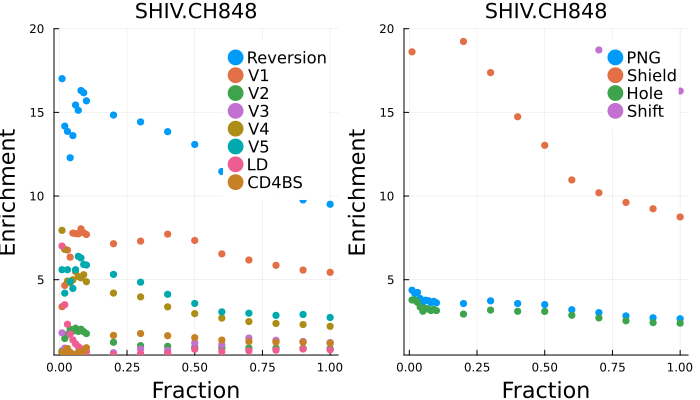

In [40]:
field_key_list = ["Reversion", "V1", "V2", "V3", "V4", "V5", "LD", "CD4BS"]
field_key_list2 = ["PNG", "Shield", "Hole", "Shift"]
p1 = Plots.plot()
for field_key in field_key_list
    idx_sel = enrichment_SHIVCH848.categories .== field_key
    scatter!(p1, enrichment_SHIVCH848.fraction[idx_sel], enrichment_SHIVCH848.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

p2 = Plots.plot()
for field_key in field_key_list2
    idx_sel = enrichment_SHIVCH848.categories .== field_key
    scatter!(p2, enrichment_SHIVCH848.fraction[idx_sel], enrichment_SHIVCH848.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

Plots.plot(p1, p2, layout=(1,2), size=(700, 400), 
    foreground_color_legend = nothing,
    labelfontsize=15, 
    xlabel="Fraction", 
    #ylim=(0.5, 500), 
    ylim=(0.5, 20), 
 #   yaxis=:log10,
    ylabel="Enrichment",
    legendfontsize=11, 
    title="SHIV.CH848"
)
#Plots.savefig("../fig_temp/enrichment_SHIV-CH848.pdf")    

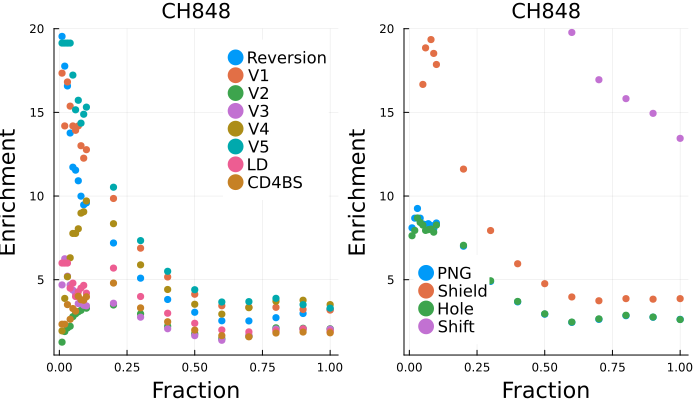

In [41]:
field_key_list = ["Reversion", "V1", "V2", "V3", "V4", "V5", "LD", "CD4BS"]
field_key_list2 = ["PNG", "Shield", "Hole", "Shift"]
p1 = Plots.plot()
for field_key in field_key_list
    idx_sel = enrichment_CH848.categories .== field_key
    scatter!(p1, enrichment_CH848.fraction[idx_sel], enrichment_CH848.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

p2 = Plots.plot()
for field_key in field_key_list2
    idx_sel = enrichment_CH848.categories .== field_key
    scatter!(p2, enrichment_CH848.fraction[idx_sel], enrichment_CH848.enrichment[idx_sel], label=field_key, markerstrokewidth=0)
end

Plots.plot(p1, p2, layout=(1,2), size=(700, 400), 
    foreground_color_legend = nothing,
    labelfontsize=15, 
    xlabel="Fraction", 
    palette = :magma,
    ylabel="Enrichment",
    ylim=(0.5, 20), 
    #yaxis=:log10,
    legendfontsize=11, 
    title="CH848"
)
#Plots.savefig("../fig_temp/enrichment_CH848.pdf")    

In [42]:
pwd()

"/net/dali/home/barton/kais/submission/HIV_Coevolution/note"